In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Config
data_dir = 'data'
train_dir = os.path.join(data_dir, 'training')
test_query_dir = os.path.join(data_dir, 'test/query')
test_gallery_dir = os.path.join(data_dir, 'test/gallery')

batch_size = 16
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
import os

print(os.path.exists(train_dir))
print(os.listdir(train_dir))  # will list subfolders/classes for training set
print(os.listdir(test_query_dir))

True
['.DS_Store', 'antelope', 'Arctic_fox', 'American_chameleon']
['4597118805213184.jpg', 'n01855672_10973.jpg']


In [5]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # returning image and filename (no label)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
# For training data (has subfolders/classes)
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# For query data (NO subfolders/classes)
query_dataset = ImageDatasetWithoutLabels(test_query_dir, transform=data_transforms['test'])
query_loader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False)

# For gallery data (depends on structure)
# Option 1: If gallery has subfolders/classes
gallery_dataset = datasets.ImageFolder(test_gallery_dir, data_transforms['test'])
gallery_loader = DataLoader(gallery_dataset, batch_size=batch_size, shuffle=False)


def get_test_loader(dir_path):
    dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

query_dataset = ImageDatasetWithoutLabels(test_query_dir, transform=data_transforms['test'])
query_loader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False)



In [21]:
def initialize_model(pretrained=True, feature_extract=True):
    model = models.resnet18(pretrained=pretrained)

    if feature_extract:
        # For feature extraction, keep the backbone and remove the classification head
        model.fc = nn.Identity()

    return model.to(device)


In [22]:
def train_model(model, dataloader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(dataloader):.4f}")

def fine_tune_model(model, num_classes):
    # Check if model.fc is a Sequential block or a single Linear layer
    if isinstance(model.fc, nn.Sequential):
        num_features = model.fc[0].in_features  # Extract from first layer in Sequential
    else:
        num_features = model.fc.in_features

    # Replace with a new Sequential block for classification
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    ).to(device)

    return model




In [13]:
def extract_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.vstack(features)

def calculate_similarity(query_features, gallery_features):
    similarities = cosine_similarity(query_features, gallery_features)
    return similarities


In [15]:
def calculate_accuracy(similarities, k=5):
    correct = 0
    for i, query_sim in enumerate(similarities):
        top_k_indices = np.argsort(query_sim)[-k:][::-1]
        if i in top_k_indices:
            correct += 1
    accuracy = correct / len(similarities)
    print(f"Top-{k} Accuracy: {accuracy:.4f}")

def visualize_retrieved_images(query_loader, gallery_loader, similarities, k=5):
    query_images, _ = next(iter(query_loader))
    gallery_images, _ = next(iter(gallery_loader))
    query_images, gallery_images = query_images.cpu(), gallery_images.cpu()

    for i, query_sim in enumerate(similarities):
        top_k_indices = np.argsort(query_sim)[-k:][::-1]
        plt.figure(figsize=(10, 2))
        plt.subplot(1, k + 1, 1)
        plt.imshow(query_images[i].permute(1, 2, 0))
        plt.title("Query")
        plt.axis('off')
        for j, idx in enumerate(top_k_indices):
            plt.subplot(1, k + 1, j + 2)
            plt.imshow(gallery_images[idx].permute(1, 2, 0))
            plt.title(f"Top {j+1}")
            plt.axis('off')
        plt.show()


Epoch 1/10 - Loss: 1.0052
Epoch 2/10 - Loss: 0.2459
Epoch 3/10 - Loss: 0.5897
Epoch 4/10 - Loss: 0.1520
Epoch 5/10 - Loss: 0.1151
Epoch 6/10 - Loss: 0.0248
Epoch 7/10 - Loss: 2.2234
Epoch 8/10 - Loss: 0.0566
Epoch 9/10 - Loss: 0.2598
Epoch 10/10 - Loss: 0.3699
Top-5 Accuracy: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


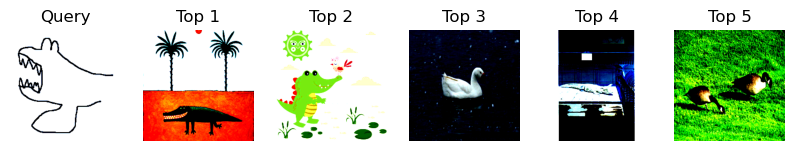

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


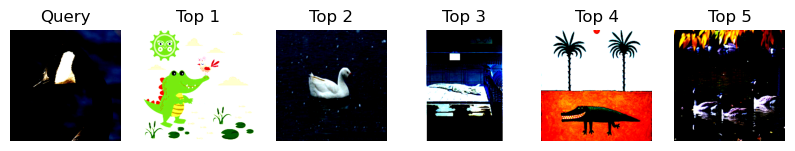

In [23]:
# Fine-tune model with classification head
model = initialize_model(pretrained=True, feature_extract=False)
num_classes = len(train_dataset.classes)
model = fine_tune_model(model, num_classes=num_classes)
train_model(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate)

# Prepare model for feature extraction by removing classification head
model.fc = nn.Identity()

# Extract features for query and gallery images
query_features = extract_features(model, query_loader)
gallery_features = extract_features(model, gallery_loader)

# Calculate similarity and evaluate
similarities = calculate_similarity(query_features, gallery_features)
calculate_accuracy(similarities, k=5)
visualize_retrieved_images(query_loader, gallery_loader, similarities, k=5)
